# WEFE Site Analyst
## implemented in Jupyter Notebook

This Jupyter Notebook collects environmental and socioeconomic data for the planning of integrated water, energy, food, and environment systems from open servers.

In [1]:
# imports
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from math import sqrt
import numpy as np
import folium
#import geojson
import overpy
import geemap
import geemap.foliumap as gfolium
import json
import requests
import ee
import webbrowser
from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON

from geopandas import GeoDataFrame

import shapely
from shapely.geometry import Polygon, shape
from shapely.geometry import LineString

# to generate word report
from docx import Document
from docx.shared import Pt, Inches, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.table import WD_ALIGN_VERTICAL
from io import BytesIO

# import files from source
os.chdir("../../src/")
import era5
import ee_layer
os.chdir("../examples/generic")

In [2]:
# set start and end date (end date will be included
# in the time period for which data is downloaded)
start_date, end_date = '2022-01-01', '2022-12-31'  # time in UTC choose start date one day before time of interest
# for position east of 0° meridian for covering all hours of interest

In [3]:
# initiate earth engine

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AeaYSHAqSbOWkXR8aOVdMu1iOFjy9s2bEf04eiSL8eACkThcvGEazrtAEu4

Successfully saved authorization token.


In [4]:
# provide case study name and coordiantes

name = input("Enter the name of the case study: ")
lat = float(input("Enter the latitude: "))
lon = float(input("Enter the longitude: "))

# test coordinates (Portugal): 37.134876382406766, -8.854069074598359

center = ee.Geometry.Point(lon, lat)

# add function to add polygon representing the parcel in case user wants it

# visualization as geemap
map = geemap.Map(center=[lat, lon], zoom=16)
map.add_basemap('SATELLITE')
map.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")
# map.add_layer(json_shape_layer)

# Display the map
map


Enter the name of the case study: permontanha
Enter the latitude: 37.134876382406766
Enter the longitude: -8.854069074598359


Map(center=[37.134876382406766, -8.854069074598359], controls=(WidgetControl(options=['position', 'transparent…

In [5]:
## TERRAIN MAP
# Define the location for which you want to create the elevation map (given abo)

# Create a single central point based on given coordinates
center = ee.Geometry.Point(lon, lat)
# Create a buffer which definies the area of interest for calculating min/max elevation, in meters in this case
buffer = center.buffer(distance=10000)

# Get the digital elevation model from earth engine
elevation = ee.Image('USGS/SRTMGL1_003')
# Create a feature, in this case the center point based on given coordinates
central_feature = ee.Feature(center, {'latitude': lat, 'longitude': lon})
# Create a feature collection from the central point, in this case the feature collection only contains one feature
fc = ee.FeatureCollection(central_feature)
# Extract elevation from digital elevation model at the central point, a scale of 30 meters is used
reducer = ee.Reducer.first()
data = elevation.reduceRegions(fc, reducer.setOutputs(['elevation']), 10)
# Get the central feature in the data, which is the first (and only) feature
feature_center = ee.Feature(data.first())
# Get the 'elevation' property from the feature
elevation_value = feature_center.get('elevation')
# Print the elevation value
print(f'Elevation at ({lat}, {lon}): {elevation_value.getInfo()} meters')

# Create a geemap map centered on the location
terrain_map = geemap.Map(center=[lat, lon], zoom=16)

# Use the 'SRTM 30m Digital Elevation Database' dataset to get elevation dataset for the buffer area
elevation_buffer_area = ee.Image('USGS/SRTMGL1_003').clip(buffer)
# Calculate statistics (min and max) for elevation within the buffer
stats = elevation_buffer_area.reduceRegion(reducer=ee.Reducer.minMax(), geometry=buffer, scale=10)
# Get minimum and maximum elevation info
min_elevation = stats.getNumber('elevation_min')
max_elevation = stats.getNumber('elevation_max')
# Get minimum and maximum elevation values
min_elevation_value = min_elevation.getInfo()
max_elevation_value = max_elevation.getInfo()
# Print the min and max elevation values
print(f'Minimum Elevation in surrounding area: {min_elevation_value} meters')
print(f'Maximum Elevation in surrounding area: {max_elevation_value} meters')

slope = ee.Terrain.slope(elevation)
# Calculate aspect. Units are degrees where 0=N, 90=E, 180=S, 270=W.
aspect = ee.Terrain.aspect(elevation);
terrain = ee.Terrain.products(elevation);

# Update visaulisation parameters based on the min and max elevation values
vis_params = {
    'min': min_elevation_value,
    'max': max_elevation_value,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

# Update visualisation parameters for the slopes in the map
vis_params_slope = {
    'min': 0,
    'max': 20,
    'palette': ['FFFFFF', '000000'],
}
terrain_map.add_basemap('SATELLITE')
terrain_map.addLayer(slope,{'min': 0, 'max': 20, 'palette': ['FFFFFF', '000000']}, 'Slope')
terrain_map.addLayer(aspect,{'min': 0, 'max': 360, 'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}, 'Aspect')
terrain_map.addLayer(terrain.select('hillshade'), {min: 0, max: 255}, 'Hillshade')
terrain_map.addLayer(elevation, vis_params, 'Elevation')
terrain_map.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")

# Make pixels with elevation below sea level transparent -> please implement
# elv_img = srtm.updateMask(srtm.gt(0))

colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']

terrain_map.add_colorbar_branca(vis_params = vis_params, colors=colors, vmin=vmin, vmax=vmax, layer_name="Elevation")

# Display the map
terrain_map

#image = terrain_map.clip(buffer).unmask()
#geemap.ee_export_image(
#image, filename='test_map.tif', scale=90, region=buffer, file_per_band=False
#)



Elevation at (37.134876382406766, -8.854069074598359): 85 meters
Minimum Elevation in surrounding area: -6 meters
Maximum Elevation in surrounding area: 220 meters


Map(center=[37.134876382406766, -8.854069074598359], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
#help(terrain_map)

# Size of the square (in degrees)
#square_size = 0.0009  # Adjust this value based on your requirement

# Calculate the coordinates of the square's corners
#half_size = square_size / 2.0
#coordinates = [
#    [lon - half_size, lat - half_size],
#    [lon - half_size, lat + half_size],
#    [lon + half_size, lat + half_size],
#    [lon + half_size, lat - half_size],
#    [lon - half_size, lat - half_size],
#]

# Create the square geometry
#geom = ee.Geometry.Polygon([coordinates])

#feature = ee.Feature(geom, {})

#roi = feature.geometry()

#filename = './test_terrain_map.jpg'

#terrain_map.to_image(filename)

# Display the map
#terrain_map
#terrain_map.fullscreen = True

In [ ]:

#output_dir = os.getcwd()
#image_export_path = os.path.join(output_dir, 'terrain_map.tif')



In [ ]:
# keep the export_image function in separate box to the terrain map generation

#image = elevation.clip(roi).unmask()

#geemap.ee_export_image(
#    image, filename=image_export_path, scale=90, region=roi, file_per_band=False
#)

In [ ]:
#terrain_map.layer_to_image('Elevation', output='test_terrain_map.jpg')
#geemap.show_image('test_terrain_map.jpg')

# Save the map as an HTML file
#html_file_path = 'test_map_2_map.html'
#terrain_map.save(html_file_path)

# Open the HTML file in fullscreen mode
#webbrowser.open('file://' + os.path.realpath(html_file_path), new=2)

#output_dir = os.getcwd()
#image_export_path = os.path.join(output_dir, 'terrain_map.jpg')
#geemap.Map.to_image(terrain_map, filename=image_export_path)

In [6]:
## LANDUSE MAP
# Define the location for which you want to create the map

center = ee.Geometry.Point(lon, lat)
buffer = center.buffer(3000)

landuse_map = gfolium.Map(center=[lat, lon], zoom=17)
dataset = ee.ImageCollection("ESA/WorldCover/v100").first()
landuse_map.add_basemap('SATELLITE')
landuse_map.addLayer(dataset, {'bands': ['Map']}, 'ESA Land Cover')
landuse_map.add_legend(builtin_legend='ESA_WorldCover')
landuse_map.addLayer(center,{'color': 'red', 'weight': 1, 'opacity': 1}, "center")
landuse_map

In [7]:
# Hydrology Map

center = ee.Geometry.Point(lon, lat)


hm = gfolium.Map(
    center=[lat, lon], zoom=17, toolbar_control=False, layers_control=True
)

hm.add_basemap('SATELLITE')

hm.addLayer(center, {'color': 'cyan', 'weight': 1, 'opacity': 0.7}, "center")

hm.add_osm_from_point(
    center_point=(lat, lon),
    tags={"natural": "water"},
    dist=5000,
    layer_name="Lakes",
)
hm.add_osm_from_point(
    center_point=(lat, lon),
    tags={"waterway":["river", "stream", "tidal_channel", "canal", "ditch", "drain", "pressurized"]},
    dist=5000,
    layer_name="waterway",
)

hm


# "amenity":"drinking_water"
#waterway=river waterway=streamwaterway=tidal_channel waterway=canal waterway=ditch waterway=drain waterway=pressurised
#natural=water
#water=*


In [8]:
## Soil Properties

#soil organic carbon
soc_mean = ee.Image("projects/soilgrids-isric/soc_mean")
print(type(soc_mean))

# Soil salinity
# Soil depth
# soil bulk density
bdod_mean = ee.Image("projects/soilgrids-isric/bdod_mean")
# Soil Cation Exchange Capacity
cec_mean = ee.Image("projects/soilgrids-isric/cec_mean")
# Soil moisture
#nitrogen
nitrogen_mean = ee.Image("projects/soilgrids-isric/nitrogen_mean")
# Soil pH (in H2O)
phh2o_mean = ee.Image("projects/soilgrids-isric/phh2o_mean")
# soil texture
clay_mean = ee.Image("projects/soilgrids-isric/clay_mean")
silt_mean = ee.Image("projects/soilgrids-isric/silt_mean")
sand_mean = ee.Image("projects/soilgrids-isric/sand_mean")

location = {
  "type": "Point",
  "coordinates": [lon, lat]
}

# Extract the soil properties for the location
soc_mean = soc_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

bdod_mean = bdod_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

cec_mean = cec_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

nitrogen_mean = nitrogen_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

phh2o_mean = phh2o_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

clay_mean = clay_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

silt_mean = silt_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()
index_list = ['0-5cm', '100-200cm', '15-30cm', '30-60cm', '5-15cm', '60-100cm']

sand_mean = sand_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

# Convert the soil properties to a pandas dataframe
soc_mean_df = pd.DataFrame.from_dict(soc_mean, orient='index', columns=["soil organic carbon [dg/kg]"])
soc_mean_df['soil_depth'] = index_list
soc_mean_df = soc_mean_df.set_index(keys='soil_depth')

bdod_mean_df = pd.DataFrame.from_dict(bdod_mean, orient='index', columns=["bulk density [cg/cm³]"])
bdod_mean_df['soil_depth'] = index_list
bdod_mean_df = bdod_mean_df.set_index(keys='soil_depth')

cec_mean_df  = pd.DataFrame.from_dict(cec_mean, orient='index', columns=["cation exchange capacity at pH 7 [mmol(c)/kg]"])
cec_mean_df['soil_depth'] = index_list
cec_mean_df = cec_mean_df.set_index(keys='soil_depth')

nitrogen_mean_df = pd.DataFrame.from_dict(nitrogen_mean, orient='index', columns=["nitrogen content [cg/kg]"])
nitrogen_mean_df['soil_depth'] = index_list
nitrogen_mean_df = nitrogen_mean_df.set_index(keys='soil_depth')

phh2o_mean_df = pd.DataFrame.from_dict(phh2o_mean, orient='index', columns=["pH of soil water [pH*10]"])
phh2o_mean_df['soil_depth'] = index_list
phh2o_mean_df = phh2o_mean_df.set_index(keys='soil_depth')

clay_mean_df = pd.DataFrame.from_dict(clay_mean, orient='index', columns=["clay content [g/kg]"])
clay_mean_df['soil_depth'] = index_list
clay_mean_df = clay_mean_df.set_index(keys='soil_depth')

silt_mean_df = pd.DataFrame.from_dict(silt_mean, orient='index', columns=["silt content [g/kg]"])
silt_mean_df['soil_depth'] = index_list
silt_mean_df = silt_mean_df.set_index(keys='soil_depth')

sand_mean_df = pd.DataFrame.from_dict(clay_mean, orient='index', columns=["sand content [g/kg]"])
sand_mean_df['soil_depth'] = index_list
sand_mean_df = sand_mean_df.set_index(keys='soil_depth')

soil_properties_df = pd.concat((soc_mean_df, bdod_mean_df, cec_mean_df, nitrogen_mean_df, phh2o_mean_df, clay_mean_df, silt_mean_df, sand_mean_df), axis=1)
print(soil_properties_df)


def soil_texture(row):
    clay =row["clay content [g/kg]"]
    silt =row["silt content [g/kg]"]
    sand =row["sand content [g/kg]"]
    
    total = clay + silt + sand
    clay_percent = clay / total * 100
    silt_percent = silt / total * 100
    sand_percent = sand / total * 100

    if sand_percent >= 50:
        return "Sand"
    elif silt_percent >= 50:
        return "Silt"
    elif clay_percent >= 50:
        return "Clay"
    elif sand_percent >= 30:
        return "Sandy Loam"
    elif silt_percent >= 30:
        return "Silt Loam"
    elif clay_percent >= 30:
        return "Clay Loam"
    else:
        return "Loam"


soil_properties_df["soil texture"] = soil_properties_df.apply(soil_texture, axis=1)
print(soil_properties_df)


soil_properties_df.to_csv('soil_properties_'+name+'.csv', index = True)



<class 'ee.image.Image'>
            soil organic carbon [dg/kg]  bulk density [cg/cm³]   
soil_depth                                                       
0-5cm                               622                    139  \
100-200cm                            73                    155   
15-30cm                             247                    144   
30-60cm                             165                    151   
5-15cm                              317                    141   
60-100cm                            100                    155   

            cation exchange capacity at pH 7 [mmol(c)/kg]   
soil_depth                                                  
0-5cm                                                 187  \
100-200cm                                             114   
15-30cm                                               147   
30-60cm                                               125   
5-15cm                                                163   
60-100cm           

In [ ]:
# download era5 dataset

variable = "wefesiteanalyst"
target_file = 'era5_wefesiteanalyst_'+name+'.nc'
print(target_file)


ds = era5.get_era5_data_from_datespan_and_position(
    variable=variable,
    start_date=start_date, end_date=end_date,
    latitude=lat, longitude=lon,
    target_file=target_file)

In [9]:
# File transformation nc to csv
# ds = xr.open_dataset('era5_wefesiteanalyst_'+name+'.nc')
ds = xr.open_dataset('era5_wefesiteanalyst_permontanha.nc')
era5_wefe = ds.to_dataframe()
# transform time: Costa Rica Time: UTC -6
# Create a date range with the desired starting date and frequency
#print(era5_wefe)
date_range = pd.date_range(start='2022-01-01 00:00:00', freq='H', periods=len(era5_wefe))
# Set the date range as the index of the DataFrame
era5_wefe.set_index(date_range, inplace=True)
# print(era5_wefe)
# print(era5_wefe.dtypes)
# convert units
# global horizontal irradiance
era5_wefe['ghi'] = (era5_wefe['ssrd'] / 3600.0)
era5_wefe['t_air'] = era5_wefe['t2m']-273.15
era5_wefe['e'] *=1000
era5_wefe['tp']*=1000


def calc_sqrt_sum_squares(df, col1, col2):
    return np.sqrt(df[col1]**2 + df[col2]**2)

era5_wefe['windspeed'] = calc_sqrt_sum_squares(era5_wefe, 'u10', 'v10')

# create new dataframe only consisting out of data for required parameters

columns = ['ghi', 't_air', 'e', 'tp', 'windspeed']
values = era5_wefe[columns].values
ep = pd.DataFrame(values, columns=columns, index = era5_wefe.index)


print(ep)
#print(ep.dtypes)

ep.to_csv('era5_wefesiteanalyst_'+name+'.csv', index=True)


                     ghi      t_air         e   tp  windspeed
2022-01-01 00:00:00  0.0   8.038361 -0.004103  0.0   1.677733
2022-01-01 01:00:00  0.0   7.764099 -0.004301  0.0   1.575956
2022-01-01 02:00:00  0.0   7.384369 -0.005064  0.0   1.605646
2022-01-01 03:00:00  0.0   7.253845 -0.005859  0.0   1.640360
2022-01-01 04:00:00  0.0   7.223938 -0.006524  0.0   1.583184
...                  ...        ...       ...  ...        ...
2024-01-01 19:00:00  0.0  15.355896 -0.023485  0.0   2.972949
2024-01-01 20:00:00  0.0  14.534607 -0.023590  0.0   2.929728
2024-01-01 21:00:00  0.0  13.910065 -0.022209  0.0   2.877176
2024-01-01 22:00:00  0.0  13.370361 -0.020098  0.0   2.303317
2024-01-01 23:00:00  0.0  13.016632 -0.017809  0.0   2.487617

[17544 rows x 5 columns]


<frozen importlib._bootstrap>:228: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [10]:
#era5_wefe = pd.read_csv(r"wefe.csv")
ep.head()
solar_irrad_total = round(ep['ghi'].sum(), 2)
print(solar_irrad_total)
windspeed_mean = round(ep['windspeed'].mean(), 2)
print(windspeed_mean)
precip_total = round(ep['tp'].sum(), 2)
print(precip_total)
temp_mean = round(ep['t_air'].mean(), 2)
print(temp_mean)

3796342.8
4.1
742.03
16.96


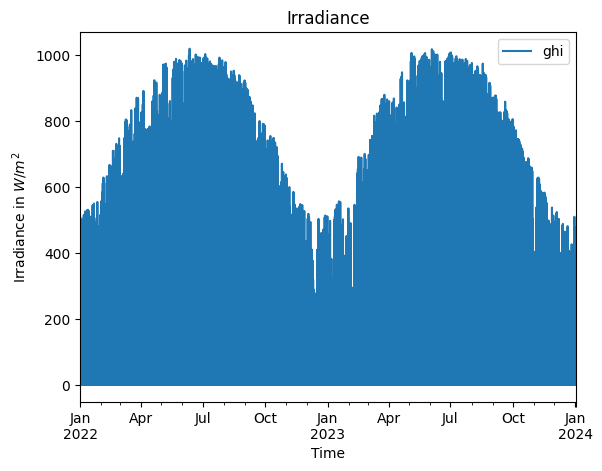

In [11]:
# global horizontal irradiance
era5_wefe.loc[:, ['ghi']].plot(title='Irradiance')
plt.xlabel('Time')
plt.ylabel('Irradiance in $W/m^2$')

solar_irrad_plot = BytesIO()
plt.savefig(solar_irrad_plot, format='png')

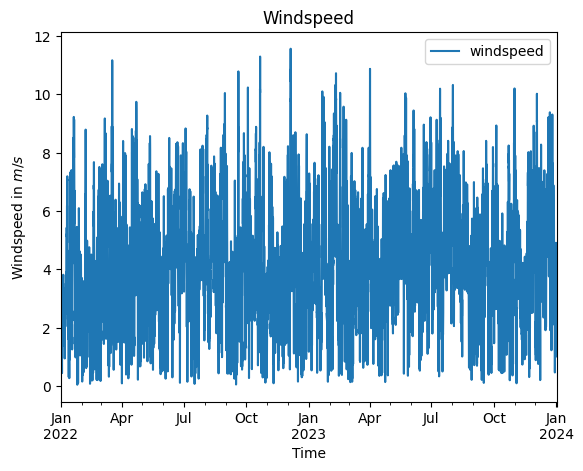

In [12]:
# windspeed
era5_wefe.loc[:, ['windspeed']].plot(title='Windspeed')
plt.xlabel('Time')
plt.ylabel('Windspeed in $m/s$')

windspeed_plot = BytesIO()
plt.savefig(windspeed_plot, format='png')

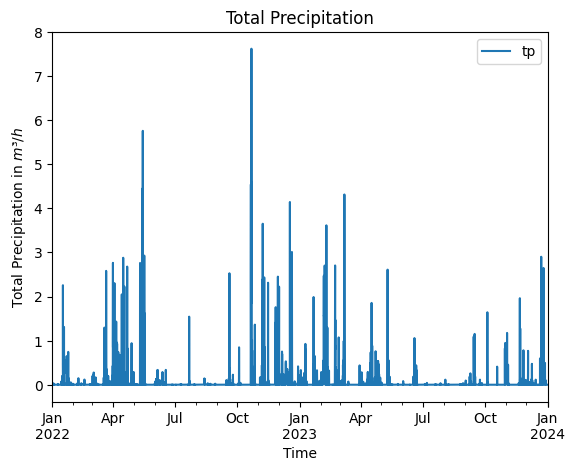

In [13]:
# plot total precipitation
era5_wefe.loc[:, ['tp']].plot(title='Total Precipitation')
plt.xlabel('Time')
plt.ylabel('Total Precipitation in $m³/h$')

precip_plot = BytesIO()
plt.savefig(precip_plot, format='png')

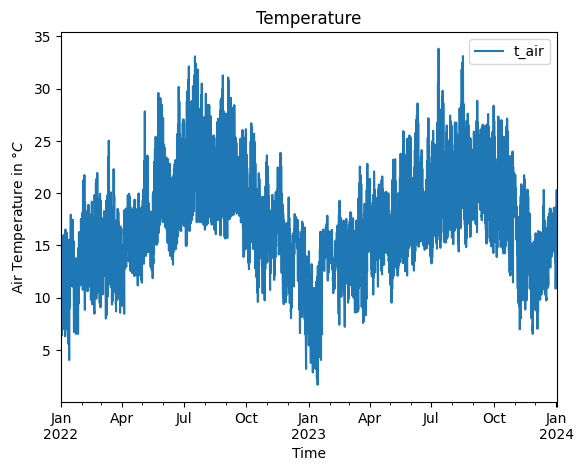

In [14]:
# plot temperature
era5_wefe.loc[:, ['t_air']].plot(title='Temperature')
plt.xlabel('Time')
plt.ylabel('Air Temperature in $°C$')

temp_plot = BytesIO()
plt.savefig(temp_plot, format='png')

In [15]:
# Function to add a paragraph with specified run style
def add_paragraph_with_styles(doc, parts):
    paragraph = doc.add_paragraph()
    for text, bold, size in parts:
        run = paragraph.add_run(text)
        run.font.bold = bold
        run.font.size = Pt(size)
    return paragraph

# Create a document object
doc = Document()

# Set default font for the entire document
default_style = doc.styles['Normal']
default_style.font.name = 'Calibri'  # Set default font to Calibri
default_style.font.size = Pt(12)  # Set default font size

# Title text for the document
title_text = f"WEFESite Analyst Report: {name} Case Study"
doc.add_heading(title_text, level=0)

# Introductory text
intro_text = (
    "WEFESiteAnalyst is an automatized remote data collection tool for the site-tailored planning of "
    "integrated Water-Energy-Food-Environment Systems (iWEFEs). "
    "This report presents findings and insights from the analysis of the case study for "
    f"{name}. The WEFESite Analyst tool aims to provide valuable information for decision-making and "
    "planning related to environmental factors, site suitability, and more. "
    "Thank you for using WEFESite Analyst for your case study analysis!"
)
add_paragraph_with_styles(doc, [(intro_text, False, 12)])

# Add Satelite Map section
doc.add_heading("Satellite Map", level=1)
satellite_map_text = "The map will be included once we figure out how to export it as an image."
add_paragraph_with_styles(doc, [(satellite_map_text, False, 12)])

# Add Terrain section
doc.add_heading("Terrain", level=1)
terrain_map_text = ("This is an example of how the elevation layer can be exported. "
                    "Note that the marked central point does not show up using this method.")
add_paragraph_with_styles(doc, [(terrain_map_text, False, 12)])
#terrain_map_image = 'test_terrain_map.jpg'
#doc.add_picture(terrain_map_image, width=Inches(4))
add_paragraph_with_styles(doc, [("Elevation value at location: ", True, 12), (f'{elevation_value.getInfo()} meters', False, 12)])

# Add Landuse section
doc.add_heading("Landuse", level=1)
landuse_map_text = "The map will be included once we decide on which method to use."
add_paragraph_with_styles(doc, [(landuse_map_text, False, 12)])
cultivated_crops_text = add_paragraph_with_styles(
    doc,
    [("Cultivated Crops: ", True, 12),
     ("It says this gets inserted manually from interview results. Need to figure out how to present this then.", False, 12)]
)

# Add Soil section to report document
doc.add_heading("Soil", level=1)
# Add an empty paragraph for spacing
doc.add_paragraph()

# Selecting only specific columns
selected_columns = ["soil organic carbon [dg/kg]", "bulk density [cg/cm³]", "cation exchange capacity at pH 7 [mmol(c)/kg]", "nitrogen content [cg/kg]"]
df_filtered_soil = soil_properties_df[selected_columns]

# Transpose the DataFrame
df_filtered_soil = df_filtered_soil.T.reset_index()

# Add a table to the document
table_soil = doc.add_table(rows=df_filtered_soil.shape[0] + 1, cols=2)  # +1 for the header row
table_soil.style = 'Light Grid Accent 1'

# Populate the header row
for j, header in enumerate(["Parameter", "Value"]):
    table_soil.cell(0, j).text = header
    table_soil.cell(0, j).vertical_alignment = WD_ALIGN_VERTICAL.CENTER  # Optional: Align text vertically to center

# Populate the table with parameter names and values
for i in range(df_filtered_soil.shape[0]):
    table_soil.cell(i + 1, 0).text = df_filtered_soil.iloc[i, 0]  # Parameter name
    table_soil.cell(i + 1, 1).text = f"{df_filtered_soil.iloc[i, 1]:.2f}"  # Parameter value
    for j in range(2):
        table_soil.cell(i + 1, j).vertical_alignment = WD_ALIGN_VERTICAL.CENTER  # Optional: Align text vertically to center

# Add Hydrology section
doc.add_heading("Hydrology", level=1)
hydrology_map_text = "The map will be included once the bug has been fixed"
add_paragraph_with_styles(doc, [(hydrology_map_text, False, 12)])

# Add Climate section
doc.add_heading("Climate", level=1)

# Add Solar Irradiance subsection
doc.add_heading("Solar Irradiance", level=2)
# Add paragraph with styles
add_paragraph_with_styles(doc, [("Total solar irradiance: ", True, 12), (f'{solar_irrad_total:.2f} kWh/m^2/a', False, 12)])
# Insert the saved image into the Word document
doc.add_picture(solar_irrad_plot, width=Inches(5.0))
# Retrieve the last paragraph in the document (should be the plot)
solar_irrad_paragraph = doc.paragraphs[-1]
# Set it to center alignment
solar_irrad_paragraph.alignment = 1
# Add an empty paragraph for spacing
doc.add_paragraph()

# Add Windspeed subsection
doc.add_heading("Windspeed", level=2)
# Add paragraph with styles
add_paragraph_with_styles(doc, [("Average windspeed: ", True, 12), (f'{windspeed_mean:.2f} m/s', False, 12)])
# Insert the saved image into the Word document
doc.add_picture(windspeed_plot, width=Inches(5.0))
# Retrieve the last paragraph in the document (should be the plot)
windspeed_paragraph = doc.paragraphs[-1]
# Set it to center alignment
windspeed_paragraph.alignment = 1
# Add an empty paragraph for spacing
doc.add_paragraph()

# Add Precipitation subsection
doc.add_heading("Precipitation", level=2)
# Add paragraph with styles
add_paragraph_with_styles(doc, [("Total precipitation: ", True, 12), (f'{precip_total:.2f} mm', False, 12)])
# Insert the saved image into the Word document
doc.add_picture(precip_plot, width=Inches(5.0))
# Retrieve the last paragraph in the document (should be the plot)
precip_paragraph = doc.paragraphs[-1]
# Set it to center alignment
precip_paragraph.alignment = 1
# Add an empty paragraph for spacing
doc.add_paragraph()

# Add Temperature subsection
doc.add_heading("Temperature", level=2)
# Add paragraph with styles
add_paragraph_with_styles(doc, [("Average temperature: ", True, 12), (f'{temp_mean:.2f} °C', False, 12)])
# Insert the saved image into the Word document
doc.add_picture(temp_plot, width=Inches(5.0))
# Retrieve the last paragraph in the document (should be the plot)
temp_paragraph = doc.paragraphs[-1]
# Set it to center alignment
temp_paragraph.alignment = 1

In [16]:
# Define report filename
report_filename = f'wefe_site_analyst_{name}.docx'
# Save the report
doc.save(report_filename)
display(doc)

In [ ]:
# retrieve area of interest from drawing/alternative in case polygon file is not available


center = ee.Geometry.Point(lon, lat)

print("please draw center of demand and area of interest into the map displayed below")


m = gfolium.Map(
    center=[lat, lon], zoom=17, toolbar_control=False, layers_control=True
)

m.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")
m.add_basemap('SATELLITE')

m
